EDA from https://www.kaggle.com/andreshg/tps-may-a-complete-analysis

In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c tabular-playground-series-jun-2021
!pip install catboost
!pip install eli5
!pip install shap
!unzip /content/test.csv.zip
!unzip /content/train.csv.zip
!unzip /content/sample_submission.csv.zip

kaggle.json
 77% 5.00M/6.49M [00:00<00:00, 17.4MB/s]
100% 6.49M/6.49M [00:00<00:00, 21.7MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 83.4MB/s]
  0% 0.00/3.14M [00:00<?, ?B/s]
100% 3.14M/3.14M [00:00<00:00, 104MB/s]
     |████████████████████████████████| 67.3MB 59kB/s 
     |████████████████████████████████| 112kB 3.0MB/s 
     |████████████████████████████████| 358kB 2.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491621 sha256=400e67ea5ed3ab5769452577a40dabf503bc0cf9c233059882b63b5f026255c5
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [2]:
!pip install colorama

In [3]:
!pip install umap-learn

     |████████████████████████████████| 81kB 2.2MB/s 
     |████████████████████████████████| 1.2MB 11.4MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=31edd8a3686d623812943ab69219f04dab415f56245e5dbe5ee3d8a6eb388714
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51362 sha256=fc99497ff1247a0bed65b740c35463dc65c783a4d2fd9f7ea5dc34401b66d353
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [4]:
import numpy as np # linear algebra
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from colorama import Fore

from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import metrics
from scipy import stats
import math

from tqdm.notebook import tqdm
from copy import deepcopy

from sklearn.preprocessing import LabelEncoder

import umap.umap_ as UMAP
#from umap import UMAP
from sklearn.manifold import TSNE

In [5]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

plt.rcParams['axes.facecolor'] = primary_bgcolor

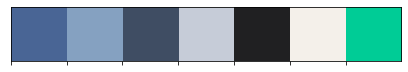

In [22]:
colors = [primary_blue, primary_blue2, primary_blue3, primary_grey, primary_black, primary_bgcolor, primary_green]
sns.palplot(sns.color_palette(colors))

In [6]:
train_df = pd.read_csv('train.csv')
train_df.columns = [column.lower() for column in train_df.columns]
# train_df = train_df.drop(columns=['passengerid'])

test_df = pd.read_csv('test.csv')
test_df.columns = [column.lower() for column in test_df.columns]

submission = pd.read_csv('sample_submission.csv')
submission.head()

train_df.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
0,0,0,0,6,1,0,0,0,0,7,0,0,0,3,0,1,0,0,3,3,1,0,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,11,0,0,0,0,0,9,0,0,0,0,0,0,3,0,1,3,0,0,0,0,0,0,0,1,1,0,0,3,0,0,0,0,0,0,2,0,0,Class_6
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,Class_6
2,2,0,0,0,0,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0,5,4,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,5,0,5,0,1,0,0,0,1,0,0,1,0,7,0,1,1,0,3,4,0,0,1,3,0,2,0,0,8,0,0,0,0,1,0,0,0,0,Class_2
3,3,0,0,7,0,1,5,2,2,0,1,2,0,5,0,0,4,0,0,22,2,1,0,0,0,0,3,0,37,0,1,3,13,0,10,0,3,1,1,0,7,0,0,2,0,1,0,0,0,0,0,0,10,0,0,25,1,0,1,2,0,2,0,7,0,0,0,0,4,0,2,2,0,4,3,0,Class_8
4,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_2


In [11]:
feature_columns = train_df.iloc[:, 1:-1].columns.values
target_column = 'target'
feature_columns

array(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13',
       'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'feature_19', 'feature_20', 'feature_21',
       'feature_22', 'feature_23', 'feature_24', 'feature_25',
       'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33',
       'feature_34', 'feature_35', 'feature_36', 'feature_37',
       'feature_38', 'feature_39', 'feature_40', 'feature_41',
       'feature_42', 'feature_43', 'feature_44', 'feature_45',
       'feature_46', 'feature_47', 'feature_48', 'feature_49',
       'feature_50', 'feature_51', 'feature_52', 'feature_53',
       'feature_54', 'feature_55', 'feature_56', 'feature_57',
       'feature_58', 'feature_59', 'feature_60', 'feature_61',
       'feature_62', 'feature_63', 'f

In [18]:
print(train_df.shape)
print(test_df.shape)

(200000, 77)
(100000, 76)


# 1. Data visualization: First Overview

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 77 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          200000 non-null  int64 
 1   feature_0   200000 non-null  int64 
 2   feature_1   200000 non-null  int64 
 3   feature_2   200000 non-null  int64 
 4   feature_3   200000 non-null  int64 
 5   feature_4   200000 non-null  int64 
 6   feature_5   200000 non-null  int64 
 7   feature_6   200000 non-null  int64 
 8   feature_7   200000 non-null  int64 
 9   feature_8   200000 non-null  int64 
 10  feature_9   200000 non-null  int64 
 11  feature_10  200000 non-null  int64 
 12  feature_11  200000 non-null  int64 
 13  feature_12  200000 non-null  int64 
 14  feature_13  200000 non-null  int64 
 15  feature_14  200000 non-null  int64 
 16  feature_15  200000 non-null  int64 
 17  feature_16  200000 non-null  int64 
 18  feature_17  200000 non-null  int64 
 19  feature_18  200000 non-

Все признаки целочисленные, пропусков нет

## 1.1 Target Variable

Рассмотрим как распределены значения целевой переменной

In [20]:
fig = px.histogram(
    train_df, 
    x=target_column, 
    color=target_column,
    color_discrete_sequence=px.colors.qualitative.G10,
)
fig.update_layout(
    title_text='Target distribution', # title of plot
    xaxis_title_text='Value', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    paper_bgcolor=primary_bgcolor,
    plot_bgcolor=primary_bgcolor,
)
fig.update_xaxes(
    title='Target class',
    categoryorder='category ascending',
)
fig.show()

Классы несбалансированы, поэтому нужно пользоваться stratified при валидации

## 1.2 General feature analysis

Рассмотрим основные статистики признаков в train

In [21]:
train_df.drop(columns=['id']).describe().T\
        .style.bar(subset=['mean'], color=px.colors.qualitative.G10[0])\
        .background_gradient(subset=['std'], cmap='Greens')\
        .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
feature_0,200000.000000,0.972710,3.941836,0.000000,0.000000,0.000000,1.000000,61.000000
feature_1,200000.000000,1.168365,3.993407,0.000000,0.000000,0.000000,1.000000,51.000000
feature_2,200000.000000,2.219325,6.476570,0.000000,0.000000,0.000000,1.000000,64.000000
feature_3,200000.000000,2.296735,7.551858,0.000000,0.000000,0.000000,1.000000,70.000000
feature_4,200000.000000,0.793530,2.935785,0.000000,0.000000,0.000000,0.000000,38.000000
feature_5,200000.000000,1.431105,5.162746,0.000000,0.000000,0.000000,1.000000,76.000000
feature_6,200000.000000,1.010695,3.949231,0.000000,0.000000,0.000000,0.000000,43.000000
feature_7,200000.000000,0.673090,2.234949,0.000000,0.000000,0.000000,0.000000,30.000000
feature_8,200000.000000,1.943980,3.931330,0.000000,0.000000,0.000000,2.000000,38.000000
feature_9,200000.000000,1.719655,5.916988,0.000000,0.000000,0.000000,1.000000,72.000000


Чем больше среднее значение, тем больше стандартное отклонение. Почти у всех признаков мединные значения равны 0 за редким исключением

## 1.3 Feature distribution by Class

Подробно разобрано в kaggle_tabular_june_2021_EDA_v1.ipynb. Распределения всех признаков смещены влево.

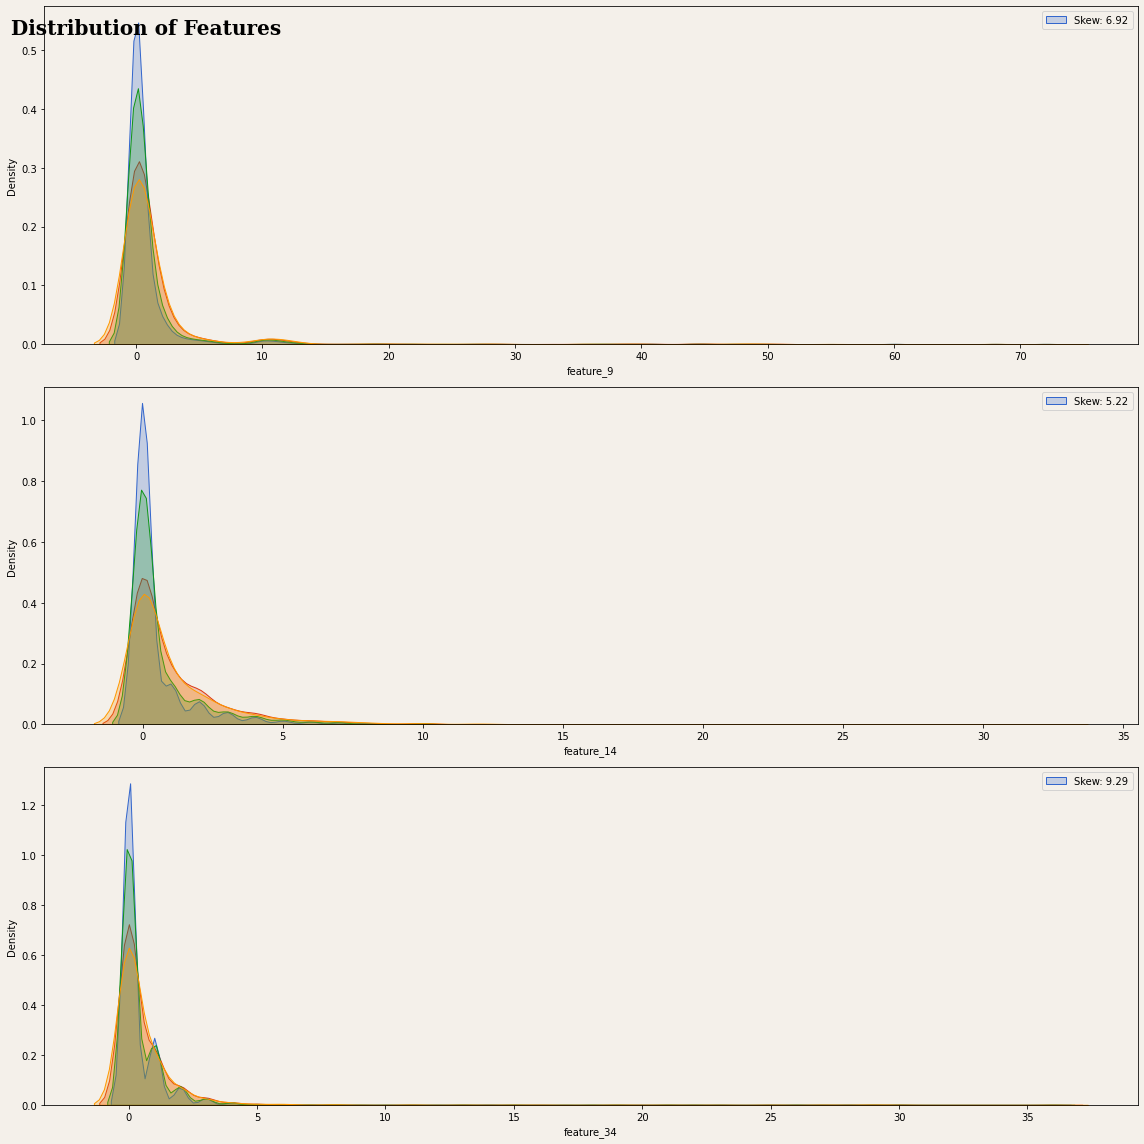

In [15]:
columns_to_plot = ['feature_9', 'feature_14', 'feature_34']

num_rows, num_cols = 3,1
f, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 16), facecolor=primary_bgcolor)
f.suptitle('Distribution of Features', fontsize=20, fontweight='bold', fontfamily='serif', x=0.13)


for index, column in enumerate(train_df[columns_to_plot].columns):
    i,j = (index // num_cols, index % num_cols)
    g = sns.kdeplot(train_df.loc[train_df[target_column] == 'Class_1', column], color=px.colors.qualitative.G10[1], shade=True, ax=axes[i])
    g = sns.kdeplot(train_df.loc[train_df[target_column] == 'Class_2', column], color=px.colors.qualitative.G10[0], label="Skew: %.2f"%(train_df[column].skew()), shade=True, ax=axes[i])
    g = g.legend(loc="best")
    sns.kdeplot(train_df.loc[train_df[target_column] == 'Class_3', column], color=px.colors.qualitative.G10[3], shade=True, ax=axes[i])
    sns.kdeplot(train_df.loc[train_df[target_column] == 'Class_4', column], color=px.colors.qualitative.G10[2], shade=True, ax=axes[i])

# f.delaxes(axes[-1, -1])
plt.tight_layout()
plt.show()

## 1.4 Correlation Analysis

In [8]:
import seaborn as sns

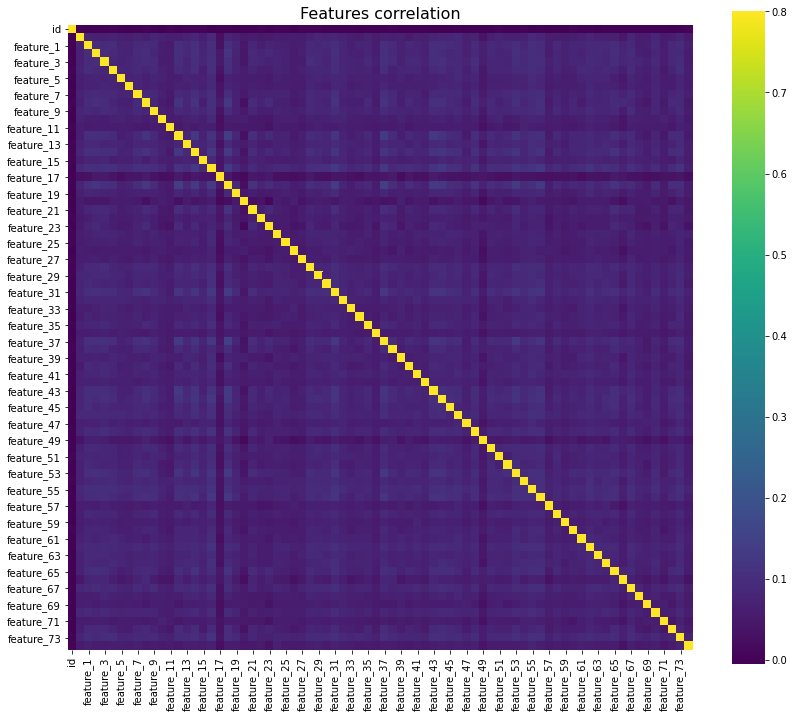

In [25]:
correlation = train_df.corr()
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Features correlation", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

Некоторые признаки имеют отличающуюся коррелящию от других (17, 49, 20, 66). Возможно они шумовые. Нужно исследовать importance для определения их важности и вычилсять их влияние на точность моделей машинного обучения

# 2. Dimension Reduction

## 2.1. t-SNE

In [27]:
tsne = TSNE(n_components=2, random_state=2021)
projections = tsne.fit_transform(train_sub[feature_columns])

In [28]:
fig = px.scatter(
    projections, x=0, y=1,
    labels={'color': 'target'},
    color=train_sub.target,
    color_discrete_sequence=px.colors.qualitative.G10,
)
fig.update_layout(
    title='<span style="font-size:24px; font-family:Serif">t-SNE</span>',
)

fig.show()

In [29]:
tsne = TSNE(n_components=3, random_state=2021)
projections = tsne.fit_transform(train_sub[feature_columns], )

In [30]:
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=train_sub.target, labels={'color': 'target'}
)
fig.update_traces(marker_size=8)
fig.show()

# 4. H2O AutoML

In [ ]:
!pip install h2o
import h2o
from h2o.automl import H2OAutoML

h2o.init()

In [34]:
%%time

train_hf = h2o.H2OFrame(train_df.copy())
test_hf = h2o.H2OFrame(test_df.copy())

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
CPU times: user 8.42 s, sys: 480 ms, total: 8.9 s
Wall time: 19.9 s


In [35]:
train_hf[target_column] = train_hf[target_column].asfactor()

In [ ]:
%%time

aml = H2OAutoML(
    seed=2021, 
    max_runtime_secs=10 * 60,
    nfolds = 3,
    exclude_algos = ["DeepLearning"]
)

aml.train(
    x=list(feature_columns), 
    y=target_column, 
    training_frame=train_hf
)

AutoML progress: |███████████████████████████████████████████████████████ (cancelled) 100%


In [ ]:
lb = aml.leaderboard 
lb.head(rows = lb.nrows)

In [ ]:
%%time

preds = aml.predict(h2o.H2OFrame(test_df[feature_columns].copy()))
preds_df = h2o.as_list(preds)
preds_df

submission[['Class_1', 'Class_2', 'Class_3', 'Class_4']] = preds_df[['Class_1', 'Class_2', 'Class_3', 'Class_4']]
submission.to_csv('h2o_automl_300s.csv', index=False)
submission.head()

# 5. LightAutoML

In [7]:
pip install -U lightautoml

     |████████████████████████████████| 256kB 2.1MB/s 
     |████████████████████████████████| 102kB 8.3MB/s 
     |████████████████████████████████| 1.2MB 14.6MB/s 
     |████████████████████████████████| 2.3MB 19.3MB/s 
     |████████████████████████████████| 430kB 25.8MB/s 
     |████████████████████████████████| 204kB 31.9MB/s 
     |████████████████████████████████| 296kB 27.8MB/s 
     |████████████████████████████████| 235kB 31.9MB/s 
     |████████████████████████████████| 38.2MB 112kB/s 
     |████████████████████████████████| 3.3MB 36.6MB/s 
     |████████████████████████████████| 901kB 39.1MB/s 
     |████████████████████████████████| 9.2MB 37.5MB/s 
     |████████████████████████████████| 174kB 50.1MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
     |████████████████████████████████| 552kB 35.4MB/s 
     |████████████████████████████████| 81kB 11.1MB/s 
     |████████████████████████████████| 143kB 40.9MB/s 
     |████████████████████████████████| 51kB 7.4MB/s

In [8]:
# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from sklearn.metrics import log_loss

In [9]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 2021 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 60 * 60 # Time in seconds for automl run

In [12]:
le = LabelEncoder()
train_df[target_column] = le.fit_transform(train_df[target_column])

In [13]:
%%time 

task = Task('multiclass',)

roles = {
    'target': target_column,
    'drop': ['id'],
}


automl = TabularUtilizedAutoML(task = task, 
                               timeout = TIMEOUT,
                               cpu_limit = N_THREADS,
                               reader_params = {'n_jobs': N_THREADS},
)

oof_pred = automl.fit_predict(train_df, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 4, 'random_state': 42}
Start automl preset with listed constraints:
- time: 3599.993173599243 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (200000, 77)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 3540.347551584244 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = -1.8450592216446995
Linear model: C = 5e-05 score = -1.8283270172849297
Linear model: C = 0.0001 score = -1.825637376434356
Linear model: C = 0.0005 score = -1.8244512396760284
Linear model: C = 0.001 score = -1.8245818756230177
Linear model: C = 0.005 score = -1.824583297238499

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Line

Time limit exceeded after calculating fold 1


Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====

0:	learn: 2.1728049	test: 2.1730550	best: 2.1730550 (0)	total: 540ms	remaining: 36m
100:	learn: 1.7608880	test: 1.7687804	best: 1.7687804 (100)	total: 41s	remaining: 26m 22s
200:	learn: 1.7444941	test: 1.7577653	best: 1.7577653 (200)	total: 1m 16s	remaining: 24m 14s
300:	learn: 1.7369694	test: 1.7553245	best: 1.7553245 (300)	total: 1m 49s	remaining: 22m 23s
500:	learn: 1.7244361	test: 1.7528771	best: 1.7528771 (500)	total: 2m 53s	remaining: 20m 13s
600:	learn: 1.7185919	test: 1.7523251	best: 1.7523251 (600)	total: 3m 24s	remaining: 19m 15s
700:	learn: 1.7131240	test: 1.7520251	best: 1.7520106 (699)	total: 3m 54s	remaining: 18m 22s
800:	learn: 1.7080102	test: 1.7518689	best: 1.7518462 (797)	total: 4m 25s	remaining: 17m 40s
900:	learn: 1.7031889	test: 1.7517333	best: 1.7516807 (870)	total: 4m 56s	remaining: 17m


Time limit exceeded after calculating fold 1


Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
Optuna may run 1 secs


Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	learn: 2.1729409	test: 2.1731485	best: 2.1731485 (0)	total: 397ms	remaining: 26m 28s
100:	learn: 1.7669339	test: 1.7726229	best: 1.7726229 (100)	total: 36.5s	remaining: 23m 29s
200:	learn: 1.7511661	test: 1.7597123	best: 1.7597123 (200)	total: 1m 10s	remaining: 22m 11s
300:	learn: 1.7457115	test: 1.7565433	best: 1.7565433 (300)	total: 1m 41s	remaining: 20m 52s
400:	learn: 1.7420037	test: 1.7548603	best: 1.7548603 (400)	total: 2m 11s	remaining: 19m 44s
500:	learn: 1.7382577	test: 1.7536908	best: 1.7536908 (500)	total: 2m 43s	remaining: 19m 2s
600:	learn: 1.7352083	test: 1.7530468	best: 1.7530455 (598)	total: 3m 12s	remaining: 18m 10s
700:	learn: 1.7325366	test: 1.7525887	best: 1.7525887 (700)	total: 3m 41s	remaining: 17m 21s
800:	learn: 1.7301623	test: 1.7522229	best: 1.7522229 (800)	total: 4m 9s	remaining: 16m 35s
900:	learn: 1.7279965	test: 1.7520129	best: 1.7520129

Time limit exceeded after calculating fold 2


Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed
Time left 570.74502825737


Time limit exceeded in one of the tasks. AutoML will blend level 1 models.                                         
Try to set higher time limits or use Profiler to find bottleneck and optimize Pipelines settings


Blending: Optimization starts with equal weights and score -1.784358433146067
Blending, iter 0: score = -1.746700515372182, weights = [0.         0.30160624 0.3570296  0.34136412]
Blending, iter 1: score = -1.7467005037777126, weights = [0.        0.3010835 0.3597519 0.3391646]
Blending, iter 2: score = -1.7467005069323505, weights = [0.         0.30089957 0.36014307 0.3389574 ]
Blending, iter 3: score = -1.7467005069323505, weights = [0.         0.30089957 0.36014307 0.3389574 ]
No score update. Terminated

Automl preset training completed in 3042.00 seconds.
oof_pred:
array([[0.01812755, 0.01758886, 0.01590149, 0.00772685, 0.00409404,
        0.75895524, 0.02983495, 0.10946985, 0.03830121],
       [0.03740356, 0.13259779, 0.0763272 , 0.02374515, 0.0093765 ,
        0.46720344, 0.03390913, 0.1128335 , 0.10660373],
       [0.05183073, 0.11258541, 0.08020045, 0.02383105, 0.01906314,
        0.15213096, 0.09430508, 0.2897971 , 0.17625609],
       [0.05312422, 0.10708079, 0.10309947, 0.02

In [14]:
%%time

test_pred = automl.predict(test_df)
print('Prediction for test set:\n{}\nShape = {}'.format(test_pred[:5], test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(log_loss(train_df[target_column].values, oof_pred.data)))

Prediction for test set:
array([[0.05341642, 0.3674457 , 0.15693584, 0.02624167, 0.01314473,
        0.1698609 , 0.02697337, 0.06295528, 0.1230261 ],
       [0.04151905, 0.08097823, 0.06230642, 0.01944338, 0.01384586,
        0.25227937, 0.08015734, 0.31854248, 0.13092792],
       [0.02118693, 0.02988328, 0.02314086, 0.01010655, 0.00617981,
        0.68193007, 0.03363194, 0.13322526, 0.06071533],
       [0.04800887, 0.11820628, 0.08116729, 0.04016643, 0.01793292,
        0.22217563, 0.07253031, 0.23824185, 0.16157044],
       [0.04196728, 0.11548459, 0.08084594, 0.02794204, 0.01455927,
        0.29853836, 0.06306354, 0.21349165, 0.14410737]], dtype=float32)
Shape = (100000, 9)
Check scores...


ValueError: ignored

In [15]:
submission.iloc[:, 1:] = test_pred.data
submission.to_csv('lightautoml_v1_1hour.csv', index = False)